Import python libraries required for the script

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rfpimp import *
from rfpimp import *
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score


Read the CSV files

In [2]:
df = pd.read_csv('VMI_Data_BP2_V02_AK6_mod02.csv')
print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'LFT_SPLICE_LENGTH',
       'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'BP2_S8_L',
       'BP2_S7_L', 'BP2_S6_L', 'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L',
       'BP2_S1_ML', 'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R',
       'BP2_S5_R', 'BP2_S6_R', 'BP2_S7_R', 'BP2_S8_R', 'PART_LENGTH',
       'LFT_SPLICE_DELTA', 'LFT_SPLICE_PREV', 'LFT_SPLICE_MA5',
       'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50',
       'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20',
       'LFT_SPLICE_SLOPE50', 'MID_SPLICE_DELTA', 'MID_SPLICE_PREV',
       'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
       'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10',
       'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',
       'RHT_SPLICE_PREV', 'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10',
       'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5',
       'RHT_SPLICE_SLOPE10', 'RHT_SPLICE_SLOPE20

In [3]:
df = df.drop(['LFT_SPLICE_LENGTH', 'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 
              'LFT_SPLICE_GRADE', 'MID_SPLICE_GRADE', 'RHT_SPLICE_GRADE', 'LFT_SPLICE_DELTA', 
              'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 
              'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50',
              'MID_SPLICE_DELTA', 'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
              'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
              'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',  'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 
              'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
              'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50',
              'PART_LENGTH', 'LFT_SPLICE_PREV','MID_SPLICE_PREV', 'RHT_SPLICE_PREV'
             ], axis=1)

for col in df.columns:
    if len(df[col].unique()) == 1:
        df = df.drop(col,inplace=True,axis=1)
        
print(df.columns)
# df['SPLICE_GRADE'].head

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP2_S8_L', 'BP2_S7_L', 'BP2_S6_L',
       'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L', 'BP2_S1_ML',
       'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R', 'BP2_S5_R', 'BP2_S6_R',
       'BP2_S7_R', 'BP2_S8_R', 'SPLICE_GRADE'],
      dtype='object')


In [4]:
print(df.shape)
df = df.drop_duplicates(subset=['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP2_S8_L', 'BP2_S7_L', 'BP2_S6_L', 'BP2_S5_L', 
                                'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L', 'BP2_S1_ML', 'BP2_S1_MR', 'BP2_S2_R', 
                                'BP2_S3_R', 'BP2_S4_R', 'BP2_S5_R', 'BP2_S6_R', 'BP2_S7_R', 'BP2_S8_R'])
print(df.shape)
# df.head

(118739, 19)
(117906, 19)


Check the columns in the data

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(5))
df = df.dropna()

                Total  Percent
SPLICE_GRADE        0      0.0
BP2_S2_L            0      0.0
CONV_WAIT_TIME      0      0.0
BP2_S8_L            0      0.0
BP2_S7_L            0      0.0


In [6]:
# pd.DataFrame({'count' : df.groupby(['SPLICE_GRADE'])['CUT_LENGTH'].size()}).reset_index()
df['SPLICE_GRADE'].value_counts()

OK      96856
Bad     20930
Good      120
Name: SPLICE_GRADE, dtype: int64

In [7]:
def numericSG(row):
    if row['SPLICE_GRADE'] == 'Bad':
        return 0
    if row['SPLICE_GRADE'] == 'OK' :
        return 1
    return 2

In [8]:
# Select equal number of each class in sample 
# df = df.groupby('SPLICE_GRADE', group_keys=False).apply(lambda x: x.sample(120))

# Convert splice grade to numeric values
# df['SPLICE_GRADE'] = df.apply(numericSG, axis=1) 

spliceGrade = {'Bad': 0, 'OK': 1, 'Good': 2} 
df.SPLICE_GRADE = [spliceGrade[item] for item in df.SPLICE_GRADE] 

# df.to_csv('temp.csv', header=True, index=False)

In [9]:
# df['SPLICE_GRADE'].to_dict()

In [10]:
# #scatter plot
# fig = plt.figure(figsize=(7, 7))
# ax = sns.scatterplot(x="SPLICE_GRADE", y="CUT_LENGTH", hue="SPLICE_GRADE", palette=['r', 'b', 'g']
#                      ,data=df)  #, palette=dict(Good='g', OK='b', Bad='r')

 
# # sns.violinplot(x="SPLICE_GRADE", y="CUT_LENGTH", data=df)
# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
X = df.drop(['SPLICE_GRADE'], axis=1)
y = df['SPLICE_GRADE']
# y = y.astype('int')

In [12]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, shuffle=True)

# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
rfc = RandomForestClassifier(n_estimators=100, warm_start=True, n_jobs=-1, random_state=7)
scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
print(scores)

# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

[0.48842337 0.66372657 0.74302434 0.73606988 0.67110508 0.61886184
 0.64105174 0.62943172 0.70619169 0.74359627]
0.6641482509661305


XGBClassifier Accuracy : 0.8229467042100621


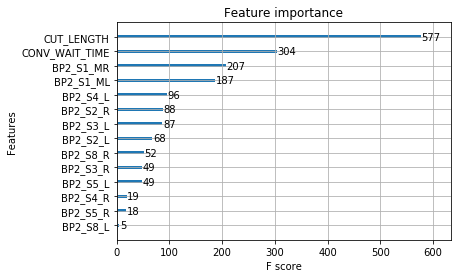

In [13]:
XGB = XGBClassifier(max_depth=5, n_estimators=500)

# rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
# rf.fit(X_train, y_train)

# imp = importances(rf, X_test, y_test) # permutation
# viz = plot_importances(imp)
# viz.view()

model = XGBClassifier()
model.fit(X_train, y_train)

y2_XGB_model = model.predict(X_test)
print("XGBClassifier Accuracy :", accuracy_score(y_test, y2_XGB_model))

# plot feature importance
plot_importance(model)
plt.show()

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
rfc = RandomForestClassifier(n_estimators=1, warm_start=True, n_jobs=-1, random_state=7)
rfc.fit(X_train,y_train)
y2_model = rfc.predict(X_test)

# print(rfc.predict([1609]))
# print(rfc.predict([[1713.377]]))


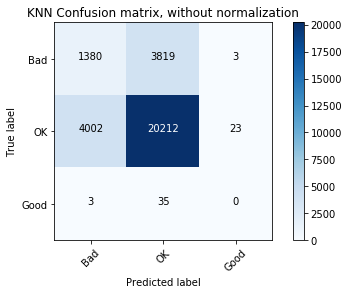

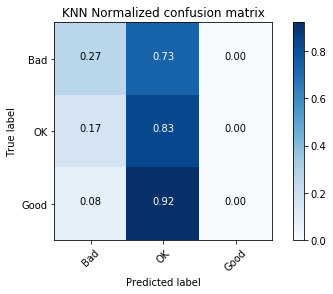

In [16]:
target_names = ['Bad', 'OK', 'Good']
class_names = target_names

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y2_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='KNN Normalized confusion matrix')

plt.show();

In [17]:
# search for an optimal value of n_estimators for rfc
k_range = list(range(50, 501, 50))
k_scores = []
for k in k_range:
    rfc = RandomForestClassifier(n_estimators=k, warm_start=True, n_jobs=-1, random_state=7)
    scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    print(k, ' -- ', scores)
print(k_scores)

50  --  [0.49 0.66 0.74 0.74 0.67 0.62 0.64 0.63 0.7  0.73]
100  --  [0.49 0.66 0.74 0.74 0.67 0.62 0.64 0.63 0.71 0.74]
150  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.74]
200  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.74]
250  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.74]
300  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.75]
350  --  [0.49 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.75]
400  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.75]
450  --  [0.48 0.67 0.75 0.74 0.67 0.62 0.64 0.63 0.71 0.75]
500  --  [0.48 0.67 0.74 0.74 0.67 0.62 0.64 0.63 0.71 0.75]
[0.659882058806371, 0.6641482509661305, 0.6645977923818638, 0.6649115845677785, 0.6649285632023793, 0.6658699893947375, 0.6667011699166189, 0.6658530510433016, 0.666395859494911, 0.6661838297765816]


Text(0, 0.5, 'Cross-Validated Accuracy')

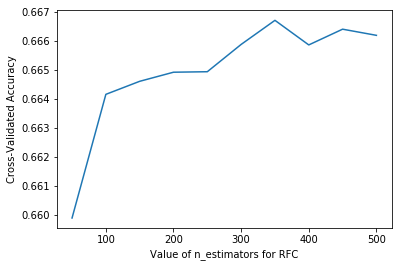

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')

In [19]:
# https://github.com/justmarkham/scikit-learn-videos/blob/master/07_cross_validation.ipynb

In [20]:
# https://github.com/justmarkham/scikit-learn-videos

In [21]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_multiclass.html#sphx-glr-auto-examples-calibration-plot-calibration-multiclass-py